# Starbucks Capstone Project

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

% matplotlib inline

# read in the json files into pandas dataframes
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Data Exploration 
## 1.a. Exploring the Portfolio dataframe

In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
print("portfolio: Rows = {0}, Columns = {1}".format(str(portfolio.shape[0]), str(portfolio.shape[1])))

portfolio: Rows = 10, Columns = 6


In [4]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [6]:
def horizontal_bar_plot(df, colName, pltTitle, pltfigsize=[5,5], bInvertYAxis=True, fntSize=12, fntWeight='bold'):
    """
    Creates a horizontal bar plot with counts of categories
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    pltTitle: The plot title.
    
    pltfigsize: The figure size of the plot (default is [5,5]).
    
    bInvertYAxis: A flag to indicating whether to invert the Y-Axis or not.
    
    fntSize: The font size of text (default to 12 point font size)
    
    fntWeight: The weight of font (default to 'bold', it could be 'italic')
    
    Returns
    -------
    None
    """
    plt.figure(figsize=pltfigsize)
    fig, ax = plt.subplots()    
    y_counts = df[colName].value_counts()
    if bInvertYAxis == True:
        y_counts.plot(kind='barh').invert_yaxis()
    else:
         y_counts.plot(kind='barh')   
    for i, v in enumerate(y_counts):
        ax.text(v, i, str(v), color='black', fontsize=fntSize, fontweight=fntWeight)
        plt.title(pltTitle)

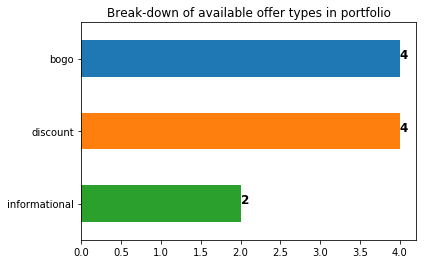

In [7]:
horizontal_bar_plot(portfolio, 'offer_type', "Break-down of available offer types in portfolio")

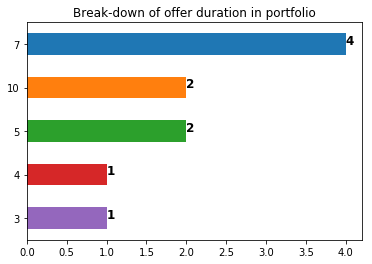

In [8]:
horizontal_bar_plot(portfolio, 'duration', "Break-down of offer duration in portfolio")

## 1.1. Exploring the transcript dataframe

In [9]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [10]:
print("transcript: Rows = {0}, Columns = {1}".format(str(transcript.shape[0]), str(transcript.shape[1])))

transcript: Rows = 306534, Columns = 4


In [12]:
transcript.describe(include="all")

,event,person,time,value
count,306534,306534,306534.000000,306534
unique,4,17000,NaN,5121
top,transaction,94de646f7b6041228ca7dec82adb97d2,NaN,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
freq,138953,51,NaN,14983
mean,NaN,NaN,366.382940,NaN
std,NaN,NaN,200.326314,NaN
min,NaN,NaN,0.000000,NaN
25%,NaN,NaN,186.000000,NaN
50%,NaN,NaN,408.000000,NaN
75%,NaN,NaN,528.000000,NaN


### 1.1.1. Let's look at all the events of the customer with most records i.e. 94de646f7b6041228ca7dec82adb97d2 in transcript data

In [13]:
transcripts_top_customer = transcript[transcript.person == '94de646f7b6041228ca7dec82adb97d2']
print("transcripts_top_customer: Rows = {0}, Columns = {1}".format(str(transcripts_top_customer.shape[0]), str(transcripts_top_customer.shape[1])))
transcripts_top_customer

transcripts_top_customer: Rows = 51, Columns = 4


,event,person,time,value
2276,offer received,94de646f7b6041228ca7dec82adb97d2,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
16010,offer viewed,94de646f7b6041228ca7dec82adb97d2,6,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
24531,transaction,94de646f7b6041228ca7dec82adb97d2,30,{'amount': 7.41}
24532,offer completed,94de646f7b6041228ca7dec82adb97d2,30,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
42252,transaction,94de646f7b6041228ca7dec82adb97d2,102,{'amount': 1.47}
55475,offer received,94de646f7b6041228ca7dec82adb97d2,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
75256,offer viewed,94de646f7b6041228ca7dec82adb97d2,186,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
77624,transaction,94de646f7b6041228ca7dec82adb97d2,192,{'amount': 2.62}
81725,transaction,94de646f7b6041228ca7dec82adb97d2,204,{'amount': 0.59}
93913,transaction,94de646f7b6041228ca7dec82adb97d2,246,{'amount': 2.2800000000000002}


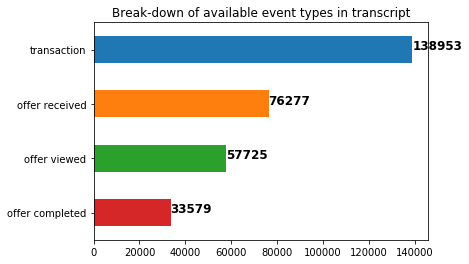

In [14]:
horizontal_bar_plot(transcript, 'event', "Break-down of available event types in transcript")

## 1.2. Exploring the profile dataframe

In [15]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [16]:
print("profile: Rows = {0}, Columns = {1}".format(str(profile.shape[0]), str(profile.shape[1])))

profile: Rows = 17000, Columns = 5


In [17]:
profile.describe(include="all")

,age,became_member_on,gender,id,income
count,17000.000000,1.700000e+04,14825,17000,14825.000000
unique,NaN,NaN,3,17000,NaN
top,NaN,NaN,M,f9fdeb1f7d384fc181891e3c0bc46be0,NaN
freq,NaN,NaN,8484,1,NaN
mean,62.531412,2.016703e+07,NaN,NaN,65404.991568
std,26.738580,1.167750e+04,NaN,NaN,21598.299410
min,18.000000,2.013073e+07,NaN,NaN,30000.000000
25%,45.000000,2.016053e+07,NaN,NaN,49000.000000
50%,58.000000,2.017080e+07,NaN,NaN,64000.000000
75%,73.000000,2.017123e+07,NaN,NaN,80000.000000


### 1.2.1. Gender counts in the profile dataframe

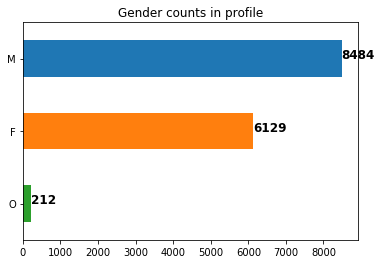

In [18]:
horizontal_bar_plot(profile, 'gender', "Gender counts in profile")

In [20]:
def exploded_pie_plot(df, colName, pltTitle, pltColors=[], pltLabels=[], pltExplode=(), pltFigSize=[5, 5]):
    """
    Creates an exploded pie plot with percentages of each categories for the column provided.
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    pltTitle: The plot title.
    
    pltColors: The array of colors to use.
    
    pltLabels: The array of plot labels to use for each of the categories.
    
    pltExplode: The proportions to pass in for exploding the slices (e.g. 0.1, 0, 0 will explode the first category out by 10%)
    
    pltFigSize: The figure size of the plot (default is [5,5])
    
    Returns
    -------
    None
    """
    plt.figure(figsize=[5, 5])
    pltValues = df[colName].value_counts()
    colors = pltColors
    labels = pltLabels
    explode = pltExplode # if (0.1, 0, 0) then explode 1st slice by 10% and dont explode 2nd and 3rd slizes
    plt.pie(pltValues, colors=pltColors, labels=pltLabels, explode=pltExplode, autopct='%1.2f%%', counterclock=False, shadow=True)
    plt.title(pltTitle)

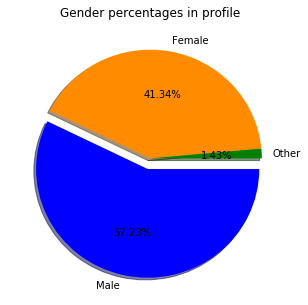

In [22]:
exploded_pie_plot(profile, 'gender', 'Gender percentages in profile', ['blue', 'darkorange', 'green'], ['Male', 'Female', 'Other'], (0.1, 0, 0))

# 2. Data Preparation and Cleaning
## 2.1 Remove invalid values and further drop rows tha make less sense for the analysis

In [23]:
profile_cleaned = profile.dropna(subset=['gender'])

In [24]:
print("profile_cleaned: Rows = {0}, Columns = {1}".format(str(profile_cleaned.shape[0]), str(profile_cleaned.shape[1])))

profile_cleaned: Rows = 14825, Columns = 5


In [25]:
median_income = 64000

profile_cleaned_income_greater_equal_median = profile_cleaned[profile_cleaned.income >= median_income]
print("profile_cleaned_income_greater_equal_median: Rows = {0}, Columns = {1}".format(str(profile_cleaned_income_greater_equal_median.shape[0]), str(profile_cleaned_income_greater_equal_median.shape[1])))

profile_cleaned_income_greater_equal_median: Rows = 7439, Columns = 5


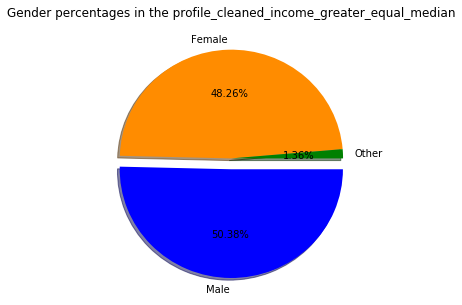

In [26]:
exploded_pie_plot(profile_cleaned_income_greater_equal_median, 'gender', 'Gender percentages in the profile_cleaned_income_greater_equal_median', ['blue', 'darkorange', 'green'], ['Male', 'Female', 'Other'], (0.1, 0, 0))

In [27]:
profile_cleaned_income_lessthan_median = profile_cleaned[profile_cleaned.income < median_income]
print("profile_cleaned_income_lessthan_median: Rows = {0}, Columns = {1}".format(str(profile_cleaned_income_lessthan_median.shape[0]), str(profile_cleaned_income_lessthan_median.shape[1])))

profile_cleaned_income_lessthan_median: Rows = 7386, Columns = 5


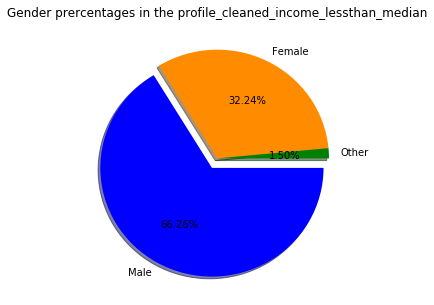

In [29]:
exploded_pie_plot(profile_cleaned_income_lessthan_median, 'gender', 'Gender prercentages in the profile_cleaned_income_lessthan_median', ['blue', 'darkorange', 'green'], ['Male', 'Female', 'Other'], (0.1, 0, 0))

In [30]:
Age_IQR1 = 45
profile_cleaned_Age_less_equal_IQR1 = profile_cleaned[profile_cleaned.age <= 45]
profile_cleaned_Age_greater_IQR1 = profile_cleaned[profile_cleaned.age > 45]

In [31]:
profile_cleaned_Age_less_equal_IQR1.shape[0]

4356

In [32]:
profile_cleaned_Age_greater_IQR1.shape[0]

10469

In [33]:
profile_cleaned_Age_less_equal_IQR1_income_greater_equal_median = profile_cleaned_Age_less_equal_IQR1[profile_cleaned_Age_less_equal_IQR1.income >= median_income]
print("profile_cleaned_Age_less_equal_IQR1_income_greater_equal_median: Rows = {0}, Columns = {1}".format(str(profile_cleaned_Age_less_equal_IQR1_income_greater_equal_median.shape[0]), str(profile_cleaned_Age_less_equal_IQR1_income_greater_equal_median.shape[1])))

profile_cleaned_Age_less_equal_IQR1_income_greater_equal_median: Rows = 1273, Columns = 5


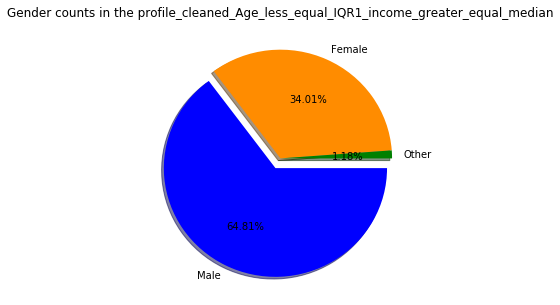

In [34]:
exploded_pie_plot(profile_cleaned_Age_less_equal_IQR1_income_greater_equal_median,'gender', 'Gender counts in the profile_cleaned_Age_less_equal_IQR1_income_greater_equal_median', ['blue', 'darkorange', 'green'], ['Male', 'Female', 'Other'], (0.1, 0, 0))

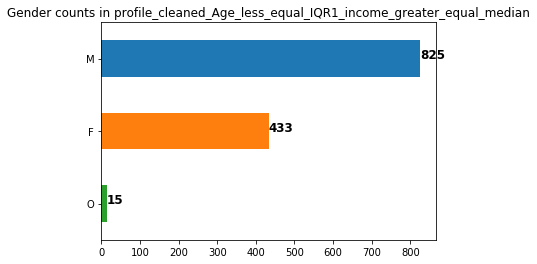

In [35]:
horizontal_bar_plot(profile_cleaned_Age_less_equal_IQR1_income_greater_equal_median, 'gender', "Gender counts in profile_cleaned_Age_less_equal_IQR1_income_greater_equal_median")

In [36]:
profile_cleaned_Age_less_equal_IQR1_income_less_median = profile_cleaned_Age_less_equal_IQR1[profile_cleaned_Age_less_equal_IQR1.income < median_income]
print("profile_cleaned_Age_less_equal_IQR1_income_less_median: Rows = {0}, Columns = {1}".format(str(profile_cleaned_Age_less_equal_IQR1_income_less_median.shape[0]), str(profile_cleaned_Age_less_equal_IQR1_income_less_median.shape[1])))

profile_cleaned_Age_less_equal_IQR1_income_less_median: Rows = 3083, Columns = 5


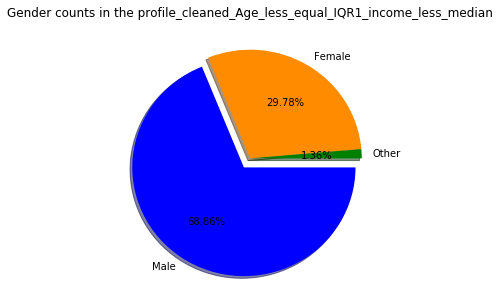

In [38]:
exploded_pie_plot(profile_cleaned_Age_less_equal_IQR1_income_less_median, 'gender', 'Gender counts in the profile_cleaned_Age_less_equal_IQR1_income_less_median', ['blue', 'darkorange', 'green'], ['Male', 'Female', 'Other'], (0.1, 0, 0))

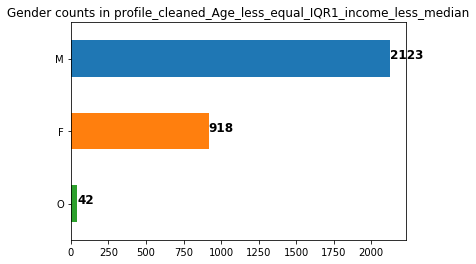

In [39]:
horizontal_bar_plot(profile_cleaned_Age_less_equal_IQR1_income_less_median, 'gender', "Gender counts in profile_cleaned_Age_less_equal_IQR1_income_less_median")

## 2.1 Check if there are customers who have not transacted at all.

In [40]:
#Create the transactions dataframe with only all user transactions i.e. with "transaction" event
transactions = transcript.loc[transcript.event == "transaction"]
print("transactions: Rows = {0}, Columns = {1}".format(str(transactions.shape[0]), str(transactions.shape[1])))

transactions: Rows = 138953, Columns = 4


In [41]:
transactions.head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [42]:
#Create transacted_customers, a vector with all unique users who were involved in a transaction i.e. with "transaction" event
transacted_customers = transactions.person.unique()
print("transacted_customers: Rows = {0}".format(str(transacted_customers.shape[0])))

transacted_customers: Rows = 16578


In [43]:
#Check the size of the profile data
print("All Existing Customers i.e. profile: Rows = {0}".format(str(profile.shape[0])))

All Existing Customers i.e. profile: Rows = 17000


### 2.1.1. We see that 17000 user profiles exists but only 16578 user profiles have a transaction with Starbucks application. We need to examine these users for their completed offers.

### 2.1.2. Since there are 422 users who have not done any transactions using the App, let's subset the profile data to exclude these users so we can analyse only the transacted users.

In [45]:
# Function: Return a boolean to check if a customer has transacted using the App
def has_customer_trasacted(customerId, transacted_customers):
    """
    Create has_transacted column to profile
    
    Parameters
    ----------
    customerId: Customer Id.
    
    transacted_customers : List of customers with one or more transactions.
     
    Returns
    -------
    boolean value if the customer with the given customer Id had transacted using the mobile app 
    """
    return customerId in transacted_customers

In [46]:
profile["has_transacted"] = profile.apply(lambda x: has_customer_trasacted(x.id, transacted_customers),axis=1)

In [47]:
profile.head()

,age,became_member_on,gender,id,income,has_transacted
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,True
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,True
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,True
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,True
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,True


In [48]:
not_transacted = profile[profile.has_transacted == False]

In [49]:
not_transacted.head()

,age,became_member_on,gender,id,income,has_transacted
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,False
90,70,20180613,F,13b7b2eccf664a329d83d2a238a9a11d,74000.0,False
92,62,20180410,F,ffc6c9fbe34b4578911dcdf6745b4c74,57000.0,False
202,81,20180503,M,accec36a10704e1fbaeb9b28b8bc5da8,93000.0,False
219,79,20180711,F,688e4f2487d44ad8bbcc0f96936f42d6,106000.0,False


In [50]:
profile_of_transacted_users = profile[profile["has_transacted"]]
profile_of_transacted_users.shape[0]

16578

In [51]:
profile_of_no_transaction_users = profile[profile["has_transacted"] == False]
profile_of_no_transaction_users.shape[0]

422

### 2.1.3. We see that both, "profile_of_transacted_users" and "profile_of_no_transaction_users" have some columns that have invalid values like, 

1. "None" in gender
2. "118" in age
3. "NaN" in income

### Let's drop these rows.

In [52]:
profile_of_transacted_users[profile_of_transacted_users['age'] == 118].shape[0]

2086

In [53]:
profile_of_transacted_users_valid = profile_of_transacted_users.dropna(subset=['gender'])
profile_of_transacted_users_valid .shape[0]

14492

In [54]:
profile_of_transacted_users_valid = profile_of_transacted_users_valid.dropna(how='all')
profile_of_transacted_users_valid.shape[0]

14492

In [55]:
profile_of_transacted_users_valid[profile_of_transacted_users_valid['age'] == 118].shape[0]

0

In [56]:
profile_of_transacted_users_valid.head()

,age,became_member_on,gender,id,income,has_transacted
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,True
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,True
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,True
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,True
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,True


### 2.1.4. Visualize the Gender distribution in profile_of_transacted_users_valid and the original profile dataframe.
1. Males in original Profile data = 8484; Males in profile_of_transacted_users_valid data = 8295
2. Females in original Profile data = 6129; Females in profile_of_transacted_users_valid data = 5993
3. Others in original Profile data = 212; Others in profile_of_transacted_users_valid data = 204

Proportion of "Males" from valid records who have not transacted = 1 - (8295/8484) = 1 - 0.9777 = 0.022 (Approx. 2.2%)

Proportion of "Females" from valid records who have not transacted = 1 - (5993/6129) = 1 - 0.9778 =  0.022 (Approx. 2.2%)

Proportion of "Others" from valid records who have not transacted = 1 -(204/212) = 1 - 0.9622 = 0.0377 (Approx. 3.8%)  

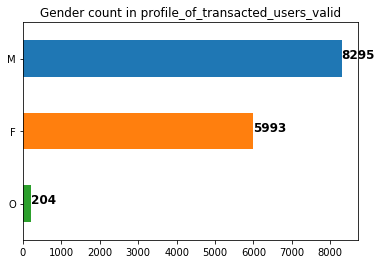

In [57]:
horizontal_bar_plot(profile_of_transacted_users, 'gender', "Gender count in profile_of_transacted_users_valid")

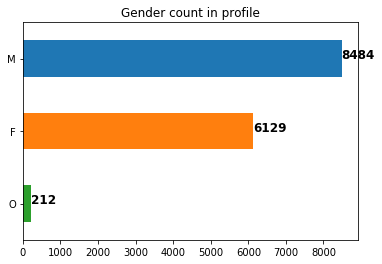

In [100]:
HorizontalBarPlot(profile, 'gender', "Gender count in profile")

### 2.1.5. Pie plot of Gender counts in profile_of_transacted_users_valid dataframe

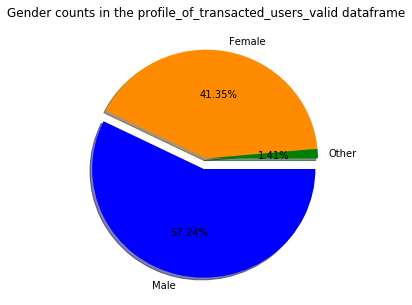

In [101]:
exploded_pie_plot(profile_of_transacted_users_valid, 'gender', 'Gender counts in the profile_of_transacted_users_valid dataframe', ['blue', 'darkorange', 'green'], ['Male', 'Female', 'Other'], (0.1, 0, 0))

# 3. Analyze the datasets

## 3.1. Read each customer events and find their influencing offers

In [102]:
def get_customer_events(customerId, transcript):
    """
    Get all the customer event rows from transcript dataframe
    
    Parameters
    ----------
    customerId: Customer Id.
    
    transcript : The transcript dataframe containing events of all customers
     
    Returns
    -------
    A dataframe with only rows for customer Id
    """
    return transcript[transcript.person == customerId] 

### 3.1.1. Influencing offers are found by looking at the completed offers and also making sure the customer viewed the offer before they completed the offer based on the key offer_id in the transcript dataframe.

*Note: A tricky part here was that in the "value" column of transcript dataframe, the dictionary keys were "offer id" i.e. with a space in the middle, for offer received and offfer viewed entries, but was "offer_id" i.e. with an underscore in the middle, for offer completed entries. So we have to be mindful of these keys.*

In [103]:
def influencing_offers(customerId, transcript):
    """
    Create a list of all Influencing offers for the passed customer Id and append.
    Influencing offers are found by looking at the completed offers and also making sure the customer viewed the offer before they completed the offer based on the key offer_id in the transcript dataframe.
    
    Parameters
    ----------
    customerId: Customer Id.
    
    transcript : The transcript dataframe containing events of all customers
     
    Returns
    -------
    A dataframe with only rows for customer Id
    """
    # Subset all events in the transcript dataframe for a given customerId
    df_customer_events = get_customer_events(customerId, transcript)
    # Subset all offer completed events in df_customer_events dataframe
    df_customer_events_completed_offers = df_customer_events[df_customer_events.event == "offer completed"]
    # Subset all offer viewed events in df_customer_events dataframe
    df_customer_events_viewed_offers = df_customer_events[df_customer_events.event == "offer viewed"]
    # Accumulate only the offers that have influenced customer transaction by checking if an offer was viewed -
    # by the customer before completing it.
    offers = []
    for i1, v1 in df_customer_events_completed_offers.iterrows():
        for i2, v2 in df_customer_events_viewed_offers.iterrows():
            if(v1['value']['offer_id'] == v2['value']['offer id'] and v2['time'] <= v1['time']):
                offers.append(v1['value']['offer_id'])
    # Return the influencing offers list for the queried customer.
    return offers

In [104]:
# Test InfluencingOffers for user 78afa995795e4d85b5d9ceeca43f5fef
offers = influencing_offers("78afa995795e4d85b5d9ceeca43f5fef", transcript)

In [105]:
offers

['9b98b8c7a33c4b65b9aebfe6a799e6d9', 'ae264e3637204a6fb9bb56bc8210ddfd']

### 3.1.2. It takes roughly about 4 minutes on a PC with i7 2.9 GHz  CPU and 16GB Ram to execute the statement below. 
We are building a column called "influencing_offers" for each user by applying a lambda function that deduces the influencing offers by looking at the list of all events in the transcript dataframe for each customer and returning a list of influencing offers.

Note: For some users there might not be an influencing offer at all. As mentioned before an influencing offer is one where the customer viewed the offer before completing it.

In [106]:
profile_of_transacted_users_valid["influencing_offers"] = profile_of_transacted_users_valid.apply(lambda x:influencing_offers(x.id, transcript),axis=1)

In [107]:
profile_of_transacted_users_valid.head(10)

,age,became_member_on,gender,id,income,has_transacted,influencing_offers
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,True,[]
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,True,"[9b98b8c7a33c4b65b9aebfe6a799e6d9, ae264e36372..."
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,True,"[9b98b8c7a33c4b65b9aebfe6a799e6d9, fafdcd668e3..."
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,True,"[f19421c1d4aa40978ebb69ca19b0e20d, 2906b810c7d..."
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,True,[fafdcd668e3743c1bb461111dcafc2a4]
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,True,"[4d5c57ea9a6940dd891ad53e9dbe8da0, f19421c1d4a..."
14,26,20140213,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,True,[]
15,62,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0,True,"[fafdcd668e3743c1bb461111dcafc2a4, 2298d6c36e9..."
16,49,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0,True,[ae264e3637204a6fb9bb56bc8210ddfd]
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,True,[2298d6c36e964ae4a3e7e9706d1fb8c2]


In [108]:
profile_of_transacted_users_valid_with_influencing_offers = profile_of_transacted_users_valid[profile_of_transacted_users_valid.influencing_offers.str.len()!=0]

In [109]:
print("profile_of_transacted_users_valid_with_influencing_offers: Rows = {0}, Columns = {1}".format(str(profile_of_transacted_users_valid_with_influencing_offers.shape[0]), str(profile_of_transacted_users_valid.shape[1])))

profile_of_transacted_users_valid_with_influencing_offers: Rows = 10998, Columns = 7


In [110]:
profile_of_transacted_users_valid_with_influencing_offers.head(10)

,age,became_member_on,gender,id,income,has_transacted,influencing_offers
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,True,"[9b98b8c7a33c4b65b9aebfe6a799e6d9, ae264e36372..."
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,True,"[9b98b8c7a33c4b65b9aebfe6a799e6d9, fafdcd668e3..."
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,True,"[f19421c1d4aa40978ebb69ca19b0e20d, 2906b810c7d..."
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,True,[fafdcd668e3743c1bb461111dcafc2a4]
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,True,"[4d5c57ea9a6940dd891ad53e9dbe8da0, f19421c1d4a..."
15,62,20160211,F,31dda685af34476cad5bc968bdb01c53,71000.0,True,"[fafdcd668e3743c1bb461111dcafc2a4, 2298d6c36e9..."
16,49,20141113,M,62cf5e10845442329191fc246e7bcea3,52000.0,True,[ae264e3637204a6fb9bb56bc8210ddfd]
18,57,20171231,M,6445de3b47274c759400cd68131d91b4,42000.0,True,[2298d6c36e964ae4a3e7e9706d1fb8c2]
20,40,20160504,F,440cf1fd7580490c971d8c651ed962af,71000.0,True,"[2298d6c36e964ae4a3e7e9706d1fb8c2, 2298d6c36e9..."
21,64,20170909,M,4b0da7e80e5945209a1fdddfe813dbe0,100000.0,True,"[0b1e1539f2cc45b7b9fa7c272da2e1d7, 0b1e1539f2c..."


In [111]:
profile_to_investigate = profile_of_transacted_users_valid_with_influencing_offers

In [112]:
profile_to_investigate.head()

,age,became_member_on,gender,id,income,has_transacted,influencing_offers
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,True,"[9b98b8c7a33c4b65b9aebfe6a799e6d9, ae264e36372..."
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,True,"[9b98b8c7a33c4b65b9aebfe6a799e6d9, fafdcd668e3..."
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,True,"[f19421c1d4aa40978ebb69ca19b0e20d, 2906b810c7d..."
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,True,[fafdcd668e3743c1bb461111dcafc2a4]
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,True,"[4d5c57ea9a6940dd891ad53e9dbe8da0, f19421c1d4a..."


## 3.2 Expand the influencing offers column into columns of all offer ids with a 1 if the customer was influenced by the offer and a 0 if they were not influenced by the offer.

In [113]:
def offer_in_influencing_offers(offerId, influencing_offers):
    """
    Find if a passed offerId is in the influencing_offers list
    
    Parameters
    ----------
    offerId: Offer Id from portfolio dataframe.
    
    influencing_offers : List of offers found for a customer
     
    Returns
    -------
    1 if offer is found 0 if not found
    """
    if (offerId in influencing_offers):
        return 1
    else:
        return 0

In [114]:
influencing_offers = profile_to_investigate.influencing_offers.iloc[0]
influencing_offers

['9b98b8c7a33c4b65b9aebfe6a799e6d9', 'ae264e3637204a6fb9bb56bc8210ddfd']

In [115]:
offer_in_influencing_offers("9b98b8c7a33c4b65b9aebfe6a799e6d9", influencing_offers)

1

In [116]:
# Apply the offer_in_influencing_offers as a lambda function to all customers rows in the profile dataframe
for offerId in portfolio.id:
    profile_to_investigate[offerId] = profile_to_investigate.apply(lambda x:offer_in_influencing_offers(offerId, x.influencing_offers), axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [79]:
profile_to_investigate.head()

,age,became_member_on,gender,id,income,has_transacted,influencing_offers,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,True,"[9b98b8c7a33c4b65b9aebfe6a799e6d9, ae264e36372...",1,0,0,1,0,0,0,0,0,0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,True,"[9b98b8c7a33c4b65b9aebfe6a799e6d9, fafdcd668e3...",0,0,0,1,0,0,1,0,0,0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,True,"[f19421c1d4aa40978ebb69ca19b0e20d, 2906b810c7d...",0,0,0,1,0,0,1,0,1,1
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,True,[fafdcd668e3743c1bb461111dcafc2a4],0,0,0,0,0,0,1,0,0,0
13,61,20170911,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,True,"[4d5c57ea9a6940dd891ad53e9dbe8da0, f19421c1d4a...",0,1,0,0,0,0,0,0,1,0


## 3.3. Drop the unwanted columns like 'has_transacted', 'influencing_offers' and 'id' from profile_to_investigate dataframe

In [117]:
profile_to_investigate = profile_to_investigate.drop(['has_transacted','influencing_offers', 'id'], axis=1)

## 3.4 One-Hot encode the gender variable by splitting it into three columns
1. gender_F	
2. gender_M	
3. gender_O

In [118]:
profile_to_investigate = pd.get_dummies(profile_to_investigate, prefix=['gender'])
profile_to_investigate.head()

,age,became_member_on,income,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,gender_F,gender_M,gender_O
3,75,20170509,100000.0,1,0,0,1,0,0,0,0,0,0,1,0,0
5,68,20180426,70000.0,0,0,0,1,0,0,1,0,0,0,0,1,0
8,65,20180209,53000.0,0,0,0,1,0,0,1,0,1,1,0,1,0
12,58,20171111,51000.0,0,0,0,0,0,0,1,0,0,0,0,1,0
13,61,20170911,57000.0,0,1,0,0,0,0,0,0,1,0,1,0,0


# 4. Build a Machine Learning model to predict if we can send an offer to a customer

## 4.1. In this section we will build a Random Forest model for each of the BOGO and discount type offers and summarize the quality of the models.

### 4.1.1. As a first step let's remove the informational offer fields form the portfolio data to focus on bogo and discount offer types.

In [119]:
complete_offer_ids = []
for offerId in portfolio.id:
    complete_offer_ids.append(offerId)
all_offer_ids  = []
all_offer_types = []
portfolio_no_informational_offer = portfolio[portfolio.offer_type != "informational"]
for offerId in portfolio_no_informational_offer.id:
    all_offer_ids.append(offerId)
for offer_type in portfolio_no_informational_offer.offer_type:
    all_offer_types.append(offer_type)
print(all_offer_ids)
print(all_offer_types)

['ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0', '9b98b8c7a33c4b65b9aebfe6a799e6d9', '0b1e1539f2cc45b7b9fa7c272da2e1d7', '2298d6c36e964ae4a3e7e9706d1fb8c2', 'fafdcd668e3743c1bb461111dcafc2a4', 'f19421c1d4aa40978ebb69ca19b0e20d', '2906b810c7d4411798c6938adc9daaa5']
['bogo', 'bogo', 'bogo', 'discount', 'discount', 'discount', 'bogo', 'discount']


### 4.1.2. Create the Features and Response columns (X and y)

In [120]:
X = profile_to_investigate.drop(complete_offer_ids, axis=1)
X.head()

,age,became_member_on,income,gender_F,gender_M,gender_O
3,75,20170509,100000.0,1,0,0
5,68,20180426,70000.0,0,1,0
8,65,20180209,53000.0,0,1,0
12,58,20171111,51000.0,0,1,0
13,61,20170911,57000.0,1,0,0


### 4.1.3. Let's "*target*" only the offer id "ae264e3637204a6fb9bb56bc8210ddfd" which is a "bogo" type

In [121]:
y = profile_to_investigate[all_offer_ids[0]]
y.head()

3     1
5     0
8     0
12    0
13    0
Name: ae264e3637204a6fb9bb56bc8210ddfd, dtype: int64

### 4.1.4. Build the simplest Random Forest Classification model with all defaults and summarize results

In [122]:
# Split records to train and test train = 80% test = 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=45)

# Create a RandomForest Classifier
basic_rf_model = RandomForestClassifier()
basic_rf_model.fit(X_train,y_train)

# Predict on test data
basic_rf_model_predictions = basic_rf_model.predict(X_test)

In [123]:
X_test.head()

,age,became_member_on,income,gender_F,gender_M,gender_O
11789,21,20160628,38000.0,0,1,0
9778,58,20160316,79000.0,0,1,0
2019,39,20170312,67000.0,0,1,0
2055,92,20160229,39000.0,1,0,0
13588,20,20171009,45000.0,1,0,0


### 4.1.5. Sumary of basic_rf_model
1. Precision of this model is 0.67
2. Recall is 0.75 
3. AUC is 0.5322
4. From the confusion matrix, out of 468 offers that influenced customers our model seems to be returning only correct predictions for 28 cases. This is not very good.

In [124]:
print(classification_report(y_test, basic_rf_model_predictions))

             precision    recall  f1-score   support

          0       0.79      0.93      0.86      2876
          1       0.21      0.07      0.11       754

avg / total       0.67      0.75      0.70      3630



In [125]:
basic_rf_model_cv_score = cross_val_score(basic_rf_model, X, y, cv=10, scoring='roc_auc')

In [126]:
print("Mean AUC Score of Basic Random Forest: ", basic_rf_model_cv_score.mean())

Mean AUC Score of Basic Random Forest:  0.539731438794


In [127]:
confusion_matrix(y_test, basic_rf_model_predictions)

array([[2681,  195],
       [ 701,   53]])

### 4.1.6. We would want to improve our basic model a bit by *tuning the hyperparameters* of the RandomForest model like,
1. Number of Random Forest trees
2. The number of features to consider when looking for the best split
3. Depth of the built trees

### The RandomSearchForBestParameters below will come in handy for tuning the hyperparameters.

In [130]:
def RandomSearchForBestParameters(n_iter, cv):
    """
    Random search for the best tree parameters
    
    Parameters
    ----------
    n_iter: Number of iterations for the random search.
    
    cv: Cross validation sample size.
     
    Returns
    -------
    n_estimators: Estimate for the number of Random Forest trees
    
    max_features: Estimate for the number of features to consider when looking for the best split
    
    max_depth: Estimate for max depth to tree splits
    """
    # Number of Random Forest trees
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # The number of features to consider when looking for the best split
    max_features = ['auto', 'sqrt', 'log2']
    # Max depth Parameter
    max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
    max_depth.append(None)
    # Specify the random grid
    random_grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth
    }
    # Random search of parameters
    rf_model_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = n_iter, cv = cv, verbose=2, random_state=42, n_jobs = -1)
    # Fit the Random Forest model
    rf_model_random.fit(X_train, y_train)
    # Summarize the best parameters
    print(rf_model_random.best_params_)
    return n_estimators, max_features, max_depth

In [131]:
n_estimators, max_features, max_depth = RandomSearchForBestParameters(n_iter=10, cv=10)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] n_estimators=1000, max_features=sqrt, max_depth=380 .............
[CV]  n_estimators=1000, max_features=sqrt, max_depth=380, total=  11.0s
[CV] n_estimators=1000, max_features=sqrt, max_depth=380 .............


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s remaining:    0.0s


[CV]  n_estimators=1000, max_features=sqrt, max_depth=380, total=  10.8s
[CV] n_estimators=1000, max_features=sqrt, max_depth=380 .............
[CV]  n_estimators=1000, max_features=sqrt, max_depth=380, total=  10.9s
[CV] n_estimators=1000, max_features=sqrt, max_depth=380 .............
[CV]  n_estimators=1000, max_features=sqrt, max_depth=380, total=  10.7s
[CV] n_estimators=1000, max_features=sqrt, max_depth=380 .............
[CV]  n_estimators=1000, max_features=sqrt, max_depth=380, total=  10.9s
[CV] n_estimators=1000, max_features=sqrt, max_depth=380 .............
[CV]  n_estimators=1000, max_features=sqrt, max_depth=380, total=  10.7s
[CV] n_estimators=1000, max_features=sqrt, max_depth=380 .............
[CV]  n_estimators=1000, max_features=sqrt, max_depth=380, total=  10.7s
[CV] n_estimators=1000, max_features=sqrt, max_depth=380 .............
[CV]  n_estimators=1000, max_features=sqrt, max_depth=380, total=  10.8s
[CV] n_estimators=1000, max_features=sqrt, max_depth=380 ......

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 23.2min finished


{'n_estimators': 1200, 'max_features': 'sqrt', 'max_depth': 460}


In [136]:
# Based on the above Random Search set the hyper-parameters 
n_estimators1 = 200
max_features1 = 'sqrt'
max_depth1 = 100

### 4.1.7. Use the tuned parameters and try building new RandomForest models on each offer type.

In [137]:
def MakeTrainTestSplits(X, y, test_size=0.33):
    """
    Create the train test splits
    
    Parameters
    ----------
    X: Number of iterations for the random search.
    
    y: Cross validation sample size.
     
    Returns
    -------
    X_train: Training samples of predictors
    
    X_test: Test samples of predictors
    
    y_train: Traning samples of observed target values
    
    y_test: Test samples of observed target values
    
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=45)
    return X_train, X_test, y_train, y_test

In [138]:
def RandomForestModel(X, y, X_train, X_test, y_train, y_test, cvsplit = 10, n_estimators=600, max_depth=420, max_features='sqrt'):
    """
    (1) Creates the Random Forest model using the X_train, y_train
    
    (2) Generates summary results, AUC and Confusion Matrix using X_test, predicted scores and y_test
    
    Parameters
    ----------
    X_train: Training samples of predictors
    
    X_test: Test samples of predictors
    
    y_train: Traning samples of observed target values
    
    y_test: Test samples of observed target values
    
    Returns
    -------
    X_train: Training samples of predictors
    
    X_test: Test samples of predictors
    
    y_train: Traning samples of observed target values
    
    y_test: Test samples of observed target values
    
    cvsplit: Cross-validation sample size (default 10)
    
    n_estimators: Number of RF Tree estimators (default 200)
    
    max_depth: Depth of RF Tree estimators (default 420)
     
    max_features: The number of features to consider when looking for the best split (default 'sqrt' of features)
    
    """
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
    rf_model.fit(X_train,y_train)
    rf_model_predictions = rf_model.predict(X_test)
    rf_model_cv_scores = cross_val_score(rf_model, X, y, cv=cvsplit, scoring='roc_auc')
    print("--------------------------")
    print("    Confusion Matrix    ")
    print("--------------------------")
    print(confusion_matrix(y_test, rf_model_predictions))
    print('\n')
    print("---------------------------------")
    print("    Classification Summary    ")
    print("---------------------------------")
    print(classification_report(y_test, rf_model_predictions))
    print('\n')
    print("--------------")
    print("    AUC    ")
    print("--------------")
    print(rf_model_cv_scores)
    print('\n')
    print("-------------------")
    print("    Mean AUC    ")
    print("-------------------")
    print("Mean AUC for Random Forest Model: ", rf_model_cv_scores.mean())
    return rf_model

In [141]:
def Build_OfferModels_Summarize_TestPredictions():
    """
    Builds the Random Forest model for the specified offer type
    
    Parameters
    ----------
    None
    
    Returns
    -------
    RforestModels: List of RandomForest models for all offer types excluding the informational offers in the portfolio dataset
    
    """
    X = profile_to_investigate.drop(complete_offer_ids, axis=1)
    cnt = 1
    RforestModels = []
    for i in all_offer_ids:
        # Choose the offer column we want to model from all_offer_ids, 
        # These are essentially now filterd to only bogo and discount offers
        y = profile_to_investigate[i]
        X_train, X_test, y_train, y_test = MakeTrainTestSplits(X,y)
        print("\n_____________________________________________________________________________\n")
        print("({0}.) Model Summary for offer id - {1} : {2}".format(cnt,i, all_offer_types[cnt-1]))
        print("_____________________________________________________________________________\n")
        RforestModels.append(RandomForestModel(X, y, X_train, X_test, y_train, y_test,  cvsplit = 10, n_estimators=n_estimators1, max_depth=max_depth1, max_features=max_features1))
        print("_____________________________________________________________________________\n")
        cnt = cnt + 1
    return RforestModels

In [140]:
RforestModels = Build_OfferModels_Summarize_TestPredictions()


_____________________________________________________________________________

(1.) Model Summary for offer id - ae264e3637204a6fb9bb56bc8210ddfd : bogo
_____________________________________________________________________________

--------------------------
    Confusion Matrix    
--------------------------
[[2748  128]
 [ 707   47]]


---------------------------------
    Classification Summary    
---------------------------------
             precision    recall  f1-score   support

          0       0.80      0.96      0.87      2876
          1       0.27      0.06      0.10       754

avg / total       0.69      0.77      0.71      3630



--------------
    AUC    
--------------
[ 0.51658951  0.54950725  0.5768919   0.5617406   0.5081898   0.55968292
  0.52990406  0.55641534  0.52611603  0.53929434]


-------------------
    Mean AUC    
-------------------
Mean AUC for Random Forest Model:  0.54243317449
______________________________________________________________________

In [142]:
RforestModels

[RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=100, max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=100, max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=100, max_features='sqrt', max_leaf_nodes=N

## 4.2. In this section we will build a Logistic Regression model for each of the BOGO and discount type offers and summarize the quality of the models.

In [143]:
y_test.head()

11789    1
9778     0
2019     0
2055     0
13588    0
Name: ae264e3637204a6fb9bb56bc8210ddfd, dtype: int64

## 4.2 Experimenting another type of model (Logistic Regression)

In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [146]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79


In [147]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

### 4.2.1 The recall rate is 0. May be not enough data for each customer to explore with simple models. Will drop this and stay with Random Forest approach.

In [149]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1745,    0],
       [ 455,    0]])

In [150]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.79      1.00      0.88      1745
          1       0.00      0.00      0.00       455

avg / total       0.63      0.79      0.70      2200



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [151]:
basic_logit_model_cv_score = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')

In [152]:
print("Mean AUC Score of logit model: ", basic_logit_model_cv_score.mean())

Mean AUC Score of logit model:  0.540862484941


 ## 4.2 In this section we will deploy the offer model on a new unseen customer predict if we should send an offer to this customer. Meaning if we receive a 1 for this offer we can go ahead and strongly send this offer to this customer. 

In [153]:
print(profile_of_no_transaction_users.shape[0])
profile_of_no_transaction_users_valid = profile_of_no_transaction_users.dropna(subset=['gender'])
profile_of_no_transaction_users_valid.shape[0]

422


333

In [154]:
profile_of_no_transaction_users_valid = profile_of_no_transaction_users_valid.dropna(how='all')
profile_of_no_transaction_users_valid.shape[0]

333

In [155]:
profile_of_no_transaction_users_valid.head()

,age,became_member_on,gender,id,income,has_transacted
90,70,20180613,F,13b7b2eccf664a329d83d2a238a9a11d,74000.0,False
92,62,20180410,F,ffc6c9fbe34b4578911dcdf6745b4c74,57000.0,False
202,81,20180503,M,accec36a10704e1fbaeb9b28b8bc5da8,93000.0,False
219,79,20180711,F,688e4f2487d44ad8bbcc0f96936f42d6,106000.0,False
225,74,20180517,F,4e5923e5deab4d5cb1624a0b1cc9909c,103000.0,False


In [156]:
profile_to_deploy = profile_of_no_transaction_users_valid.drop(['has_transacted', 'id'], axis=1)
profile_to_deploy.head()

,age,became_member_on,gender,income
90,70,20180613,F,74000.0
92,62,20180410,F,57000.0
202,81,20180503,M,93000.0
219,79,20180711,F,106000.0
225,74,20180517,F,103000.0


In [157]:
profile_to_deploy = pd.get_dummies(profile_to_deploy, prefix=['gender'])
profile_to_deploy.head()

,age,became_member_on,income,gender_F,gender_M,gender_O
90,70,20180613,74000.0,1,0,0
92,62,20180410,57000.0,1,0,0
202,81,20180503,93000.0,0,1,0
219,79,20180711,106000.0,1,0,0
225,74,20180517,103000.0,1,0,0


In [158]:
# deploy models on test data
RforestModels_0_predictions = RforestModels[0].predict(profile_to_deploy)
RforestModels_1_predictions = RforestModels[1].predict(profile_to_deploy)
RforestModels_2_predictions = RforestModels[2].predict(profile_to_deploy)
RforestModels_3_predictions = RforestModels[3].predict(profile_to_deploy)
RforestModels_4_predictions = RforestModels[4].predict(profile_to_deploy)
RforestModels_5_predictions = RforestModels[5].predict(profile_to_deploy)
RforestModels_6_predictions = RforestModels[6].predict(profile_to_deploy)
RforestModels_7_predictions = RforestModels[7].predict(profile_to_deploy)

In [159]:
np.unique(RforestModels_0_predictions, return_counts=True)

(array([0, 1]), array([323,  10]))

In [160]:
np.unique(RforestModels_1_predictions, return_counts=True)

(array([0, 1]), array([318,  15]))

In [161]:
np.unique(RforestModels_3_predictions, return_counts=True)

(array([0, 1]), array([329,   4]))

In [162]:
np.unique(RforestModels_4_predictions, return_counts=True)

(array([0, 1]), array([303,  30]))

In [163]:
np.unique(RforestModels_5_predictions, return_counts=True)

(array([0, 1]), array([282,  51]))

In [164]:
np.unique(RforestModels_6_predictions, return_counts=True)

(array([0, 1]), array([303,  30]))

In [165]:
np.unique(RforestModels_7_predictions, return_counts=True)

(array([0, 1]), array([324,   9]))

# Conclusion
### From the above deployment results, we see that for each offers we are mostly getting 0's indicating no recommended offers and only few 1's for customers to recommend. This can be attributed to the fact that our Random Forest model is still in its early stages and needs more data to improve its precision and recall. 

### In such cases, we should not completely rely on this one model. It would be better if we can use an hybrid approach of using this models and also performing a targeted offer search based on the demographic information. We will call that as Heuristic approach. This approach is recorded in the targete_offers.py file.